## Basic flow in an examplary MIR - classification research task

This notebook is designed to demonstrate basic/common flow of processes in an MIR classification task: "Automatic instrument recognition". The content should be considered as educational material rather than research material. Various segments of it aim to raise a question for discussion rather than presenting a state-of-the-art solution. Indeed, the process has a problem that we later observe and discuss close to the end, try spotting it yourself while reading the code.
![MIR classification task basic flow](https://raw.githubusercontent.com/MTG/MIRCourse/master/notebooks/figures/MIRresearchOverview_1.png)

**In-class discussion topics:**
* Defining the problem and the context, data space, reqirements, specifications <-> Literature review
* Curating a representative research dataset (available datasets, common/standard representation formats)
* Designing the flow, algorithms/processes/methods and implementation
* Evaluation

**Reading list:** https://sites.google.com/site/mirspring2018/my-reading-list


## A classification task: instrument recognition

* Let's pick one of the standard MIR tasks: automatic instrument recognition, and limit our context as monophonic isolated notes recordings.
* The task is a classification task; hence, our first aim is gather a set of isolated note recordings for various instruments with instrument labels. We will be using (downloading) samples from an existing recording collection ([the IOWA:MIS dataset](http://theremin.music.uiowa.edu/MIS.html))
* Our algorithmic design will be based on the standard flow of feature extraction followed by feeding the data to a classifier  (see figure below)
* At the end, we will use standard evaluation measures of automatic classification to test our approach.

In [ ]:
#Basic imports
import os
import matplotlib.pyplot as plt
import essentia.standard as ess
import numpy as np


## Collecting raw data and investigating its nature

### Downloading dataset files

**Collect file lists for each instrument**

In [ ]:
import pandas as pd
import os
import glob

# Load metadata with correct encoding and delimiter
metadata_path = "/Users/arnaumartin/Desktop/3r_uni/Taller tecnologia musical/dataset/Birds Voice.csv"
metadata = pd.read_csv(metadata_path, encoding="utf-8")


# Define base path for audio files
audio_base_dir = "/Users/arnaumartin/Desktop/3r_uni/Taller tecnologia musical/dataset/Voice of Birds"

# Match audio files with metadata labels
bird_files = []
for _, row in metadata.iterrows():
    bird_name = row["common_name"]
    bird_folder = bird_name.replace("/", "-") + "_sound"
    full_folder_path = os.path.join(audio_base_dir, bird_folder)
    if os.path.exists(full_folder_path):
        mp3_files = glob.glob(os.path.join(full_folder_path, "*.mp3"))
        for f in mp3_files:
            bird_files.append({"path": f, "label": bird_name})

# Organize by label
bird_files_dict = {}
for item in bird_files:
    label = item["label"]
    bird_files_dict.setdefault(label, []).append(item["path"])

print("✅ Loaded bird audio files grouped by label.")


✅ Loaded bird audio files grouped by label.


Now that we have gather a small research dataset, we can now focus designing the basic flow for our classification task

![Basic flow](https://raw.githubusercontent.com/MTG/MIRCourse/master/notebooks/figures/classification_basicFlow.png)

### Investigating and preprocessing raw data

It is often very useful to first check a few samples from the dataset to decide what preprocessing steps are required. Let's have a look at the waveform of one sample recording for each instrument

In [ ]:
# Raw-data preprocess analysis parameters
fs = 44100

num_birds = len(bird_files_dict.keys())
print("Sample waveform plots")
plt.figure(1, figsize=(5 * num_birds, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i,bird in enumerate(bird_files_dict.keys()):
    sample_file = bird_files_dict[bird][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(1,num_birds,(i+1))
    plt.plot(x)
    plt.title(bird)

Sample waveform plots


[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input


The recordings include a series of isolated notes for flute, violin and Eb-Clarinet and isolated notes for vibraphone. We could split the series of isolated notes to create the samples.

Splitting/segmentation could be performed based on energy threshold. Below, a list of heuristically selected values are used. 

### Preprocessing of raw data: Segmentation, splitting, alignment,... 

While common preprocessing steps (such as amplitude normalisation) exist, there is often some dataset and task specific preprocessing tasks required for grouping, cleaning, and format change. 

In the downloaded dataset, recordings include a sequence of isolated notes played in sequence which could be split into isolated notes. We would like to investigate the option of splitting using a fixed energy threshold (which would help us seperate notes using the silence regions). Let's define a function to perform this operation and visualize some samples to observe the effectiveness of it.

In [ ]:
# Raw-data preprocess analysis parameters
windowSize = 4096 * 4
hopSize = 4096 * 2
NRG_threshold_ratio = 0.01 #threshold expressed as ratio with respect to the maximum value
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [ ]:
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

Let's visualize three files per instrument to check if the splits look fine.

Sample plots for waveform versus energy and splits based on energy threshold


[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping 

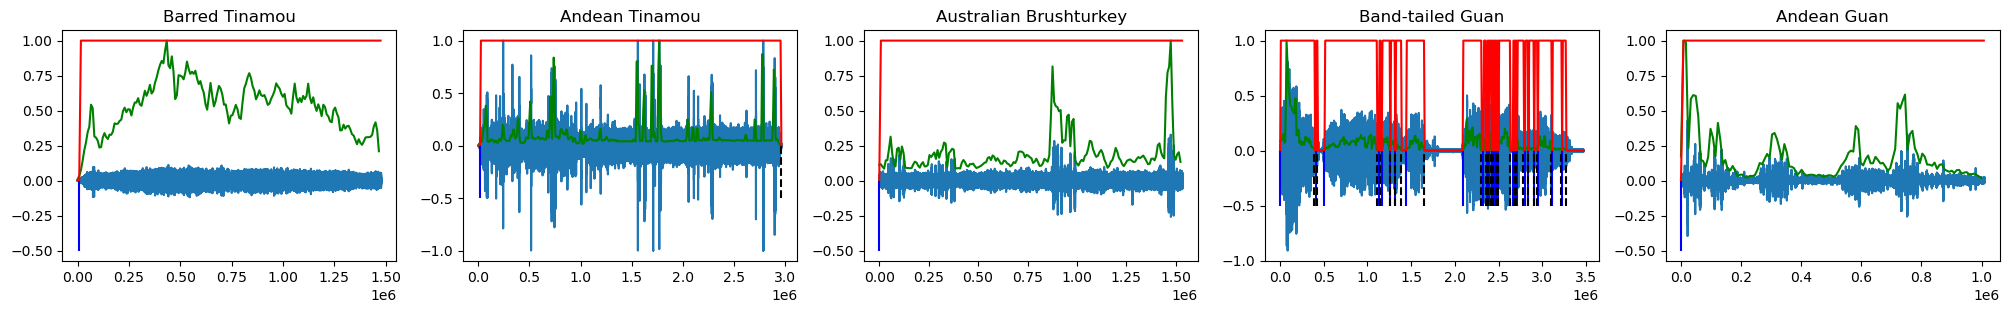

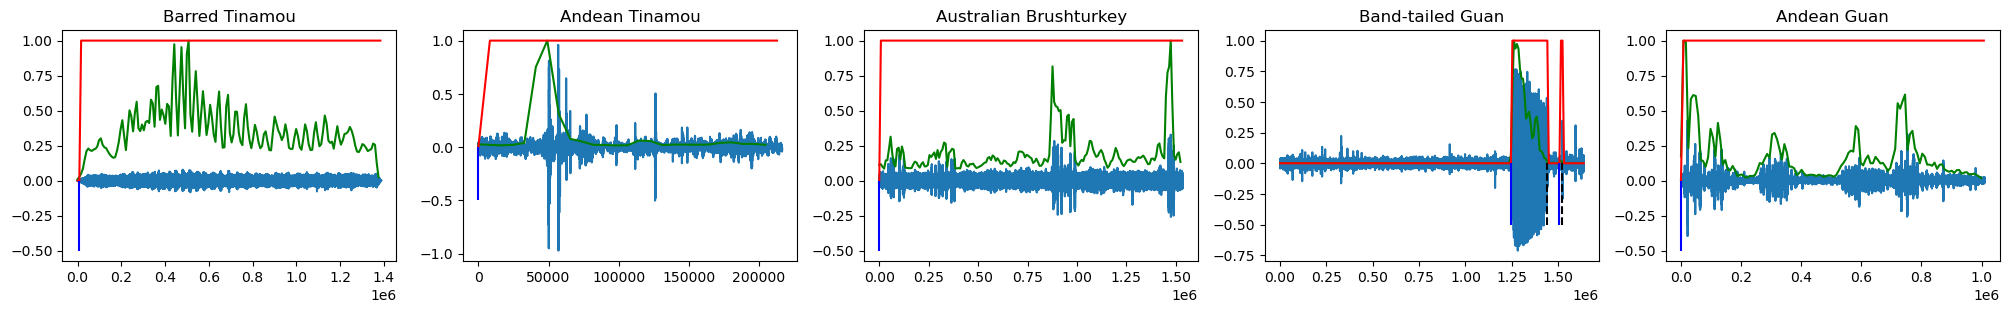

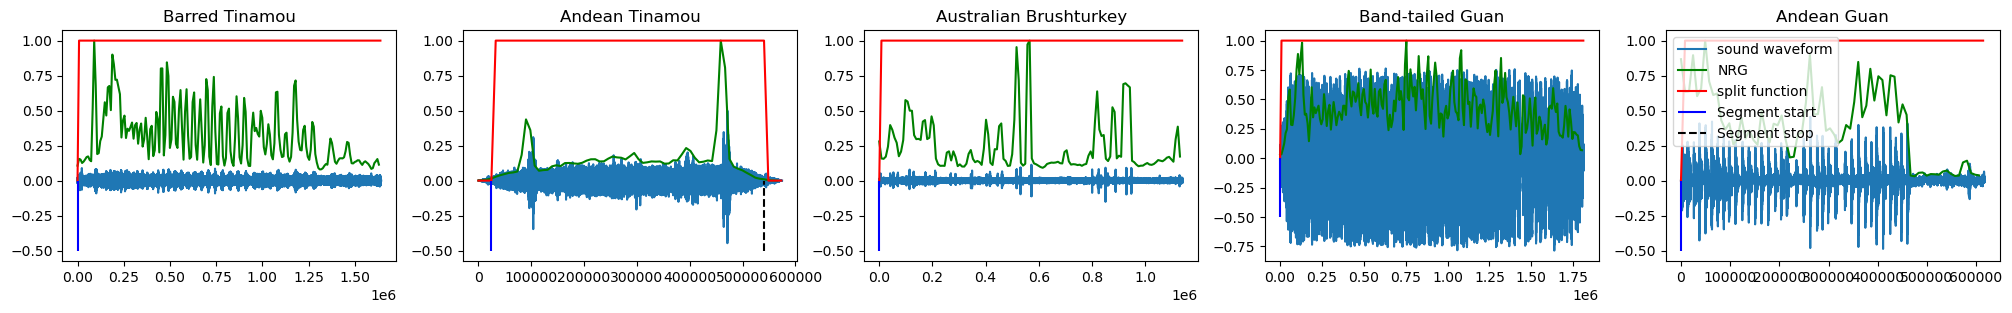

In [ ]:
num_birds = len(bird_files_dict.keys())
print("Sample plots for waveform versus energy and splits based on energy threshold")

file_indexes = [0, 1, 2]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_birds, 3))
    for i, bird in enumerate(bird_files_dict.keys()):
        sample_file = bird_files_dict[bird][file_ind_inlist]
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Plotting functions for checking the split decisions
        plt.subplot(1,num_birds,(i+1))
        plt.title(bird)
        plt.plot(x, label = 'sound waveform')
        plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
        plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
        plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
        plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");


The decision boundaries look fine, let's use the function to 
* get segment boundaries and crop segments, 
* amplitude normalize them and save all segments in a new folder

In [ ]:
segments_dir = os.path.join('/Users/arnaumartin/Desktop/3r_uni/Taller tecnologia musical/dataset','segments')
if not os.path.exists(segments_dir):#creating the directory
    os.mkdir(segments_dir)

segment_files = []
for bird, files in bird_files_dict.items():
    file_count = 0
    for sample_file in files:
        x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Croping segments
        for start, stop in zip(start_indexes, stop_indexes):
            if stop - start > fs/3:#let's only keep segments larger than 1/3 second
                x_seg = x[start: stop]
                #Final check for amplitude (to avoid silent segments selection due to noise in split function)
                if(np.max(np.abs(x_seg)) > 0.05):
                    #Amplitude normalisation
                    x_seg = x_seg / np.max(np.abs(x_seg))
                    filename = os.path.join(segments_dir, bird + '_' + str(file_count) + '.wav')
                    ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
                    file_count +=1
                    segment_files.append(filename)

print(len(segment_files),'segment files created')

[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input
[ WARNING  ] AudioLoader: invalid frame, skipping 

In [ ]:
#If required, you can use this cell to delete all files in a given folder
def delete_files_in_dir(dir_name):
    '''Deleting all files in a directory
    '''
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            file_name = os.path.join(root,file)
            os.remove(file_name);print(file_name, 'removed');

#delete_files_in_dir(segments_dir)

Segments saved into separate files. Check the "data/instrument/segments/" folder.

## Feature extraction 

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

Let's first run it for a file and check its output:

In [ ]:
import essentia.standard as es

#Running music extractor for a file:
file = segment_files[0]#simply pick the first file in the list
features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  lowlevelStats = ['mean', 'stdev'])(file)

[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done


Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [ ]:
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

Running musicextractor for all files, keeping a subset of features, writing to an output file: data.csv

In [ ]:
#Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = os.path.join(segments_dir,'data.csv')
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['bird']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for file in segment_files:
        if '.wav' in file:
            file_count +=1
            if file_count % 20 == 0:#print name of a file every 20 files
                print(file_count, "files processed, current file: ",file)
            features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(file)
            selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
            bird = file.split('/')[-1].split('_')[0].lower()#class information
            line2write = str(selected_features)[1:-1] + ',' + bird + '\n'
            writer.write(line2write)
print("A total of ",file_count, "files processed")

[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame

20 files processed, current file:  instrument/segments/Violin_19.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features

40 files processed, current file:  instrument/segments/Violin_39.wav


[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent 

60 files processed, current file:  instrument/segments/Violin_59.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtrac

80 files processed, current file:  instrument/segments/EbClar_3.wav


[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Re

100 files processed, current file:  instrument/segments/EbClar_23.wav


[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent 

120 files processed, current file:  instrument/segments/Vibraphone_4.wav


[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[ WARNING  ] Danceability: Zero detrended fluctuation value has been found. Setting danceability value to 0.
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[  

140 files processed, current file:  instrument/segments/Vibraphone_24.wav


[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[ WARNING  ] Danceability: Zero detrended fluctuation value has been found. Setting danceability value to 0.
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[ WARNING  ] Danceability: Zero detrended fluctuation value has been found. Setting danceability value to 0.
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[ WARNIN

160 files processed, current file:  instrument/segments/flute_2.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

180 files processed, current file:  instrument/segments/flute_22.wav
A total of  193 files processed


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done


## Analysis and preprocessing of features

All extracted features are saved in data.csv. Columns represent features and rows files/samples. This is a typical format in a large number of machine learning datasets (see a few of the dataset here: https://archive.ics.uci.edu/ml/index.php or other "Data Science" examples on the web).  

***The use of a common format for data representation is beneficial in both making use of existing tools/libraries (such as Pandas) and contributing to the community with resources that are easy to use.***

Let's load the data and start investigating the features. We can use Pandas (a package largely used in data science) to read data and access statistical description of the features. 

In [ ]:
import pandas as pd

In [ ]:
#Read data
data = pd.read_csv(data_file)
#Let's see the first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,instrument
0,0.990684,10.252393,4.152942,0.315984,0.101179,1.153163,3.042033,0.846861,0.504853,14.286882,...,676.993347,2.624878,3.452084,2480410.50,7.203082e+05,0.805182,0.402247,0.038239,0.017058,violin
1,0.990684,16.884533,2.678829,0.419626,0.083713,13.272852,5.331847,2.499212,1.173819,4.695795,...,310.422668,2.578309,2.941619,2599073.50,2.934197e+06,1.074569,0.347106,0.025707,0.007652,violin
2,0.944595,13.774095,4.277797,0.357864,0.116356,21.596279,80.104248,2.307978,3.386952,12.036757,...,482.731934,3.236233,3.591056,2948750.00,2.359059e+06,1.104074,0.987396,0.021126,0.013383,violin
3,0.990684,19.506229,3.474031,0.345324,0.123666,9.289896,12.184218,1.872819,1.882406,11.173414,...,654.692993,2.634136,3.364928,3345225.25,3.088169e+06,1.622710,0.740537,0.017263,0.007664,violin
4,0.990684,21.031853,3.793587,0.357715,0.083720,7.965714,17.061729,2.097800,1.327785,12.633143,...,704.621582,1.977559,1.943702,3313759.25,2.665149e+06,2.073487,0.666742,0.027887,0.011652,violin


All features are represented with columns, and the last column ('instrument') carries the class information.

Always check if your data involves NaN values and clean them (by simply removing the sample, or replacing the NaN value by a real value (such as the median of that feature)).

In [ ]:
data.isnull().sum().sum()#sums a matrix of True/False values obtained by checking if each value is Nan

0

**Observation:** No NaN value, proceed ..

We can plot samples on two-dimensional feature spaces to check if features are discriminative for those classes. Here is an example:

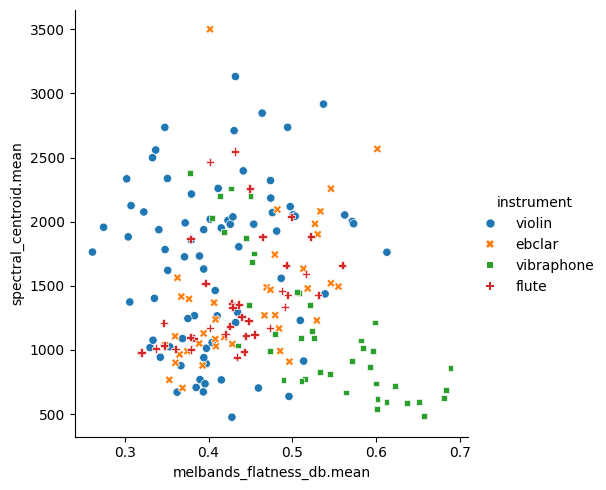

In [ ]:
import seaborn as sns
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "bird", style = "bird", data = data);

The Seaborn package includes some very useful plotting functions that facilitate such visual inspections. Here is another example: this time producing plots **for the last 6 features**, creating all combinations to form 2-dimensional feature spaces representing the samples from different classes

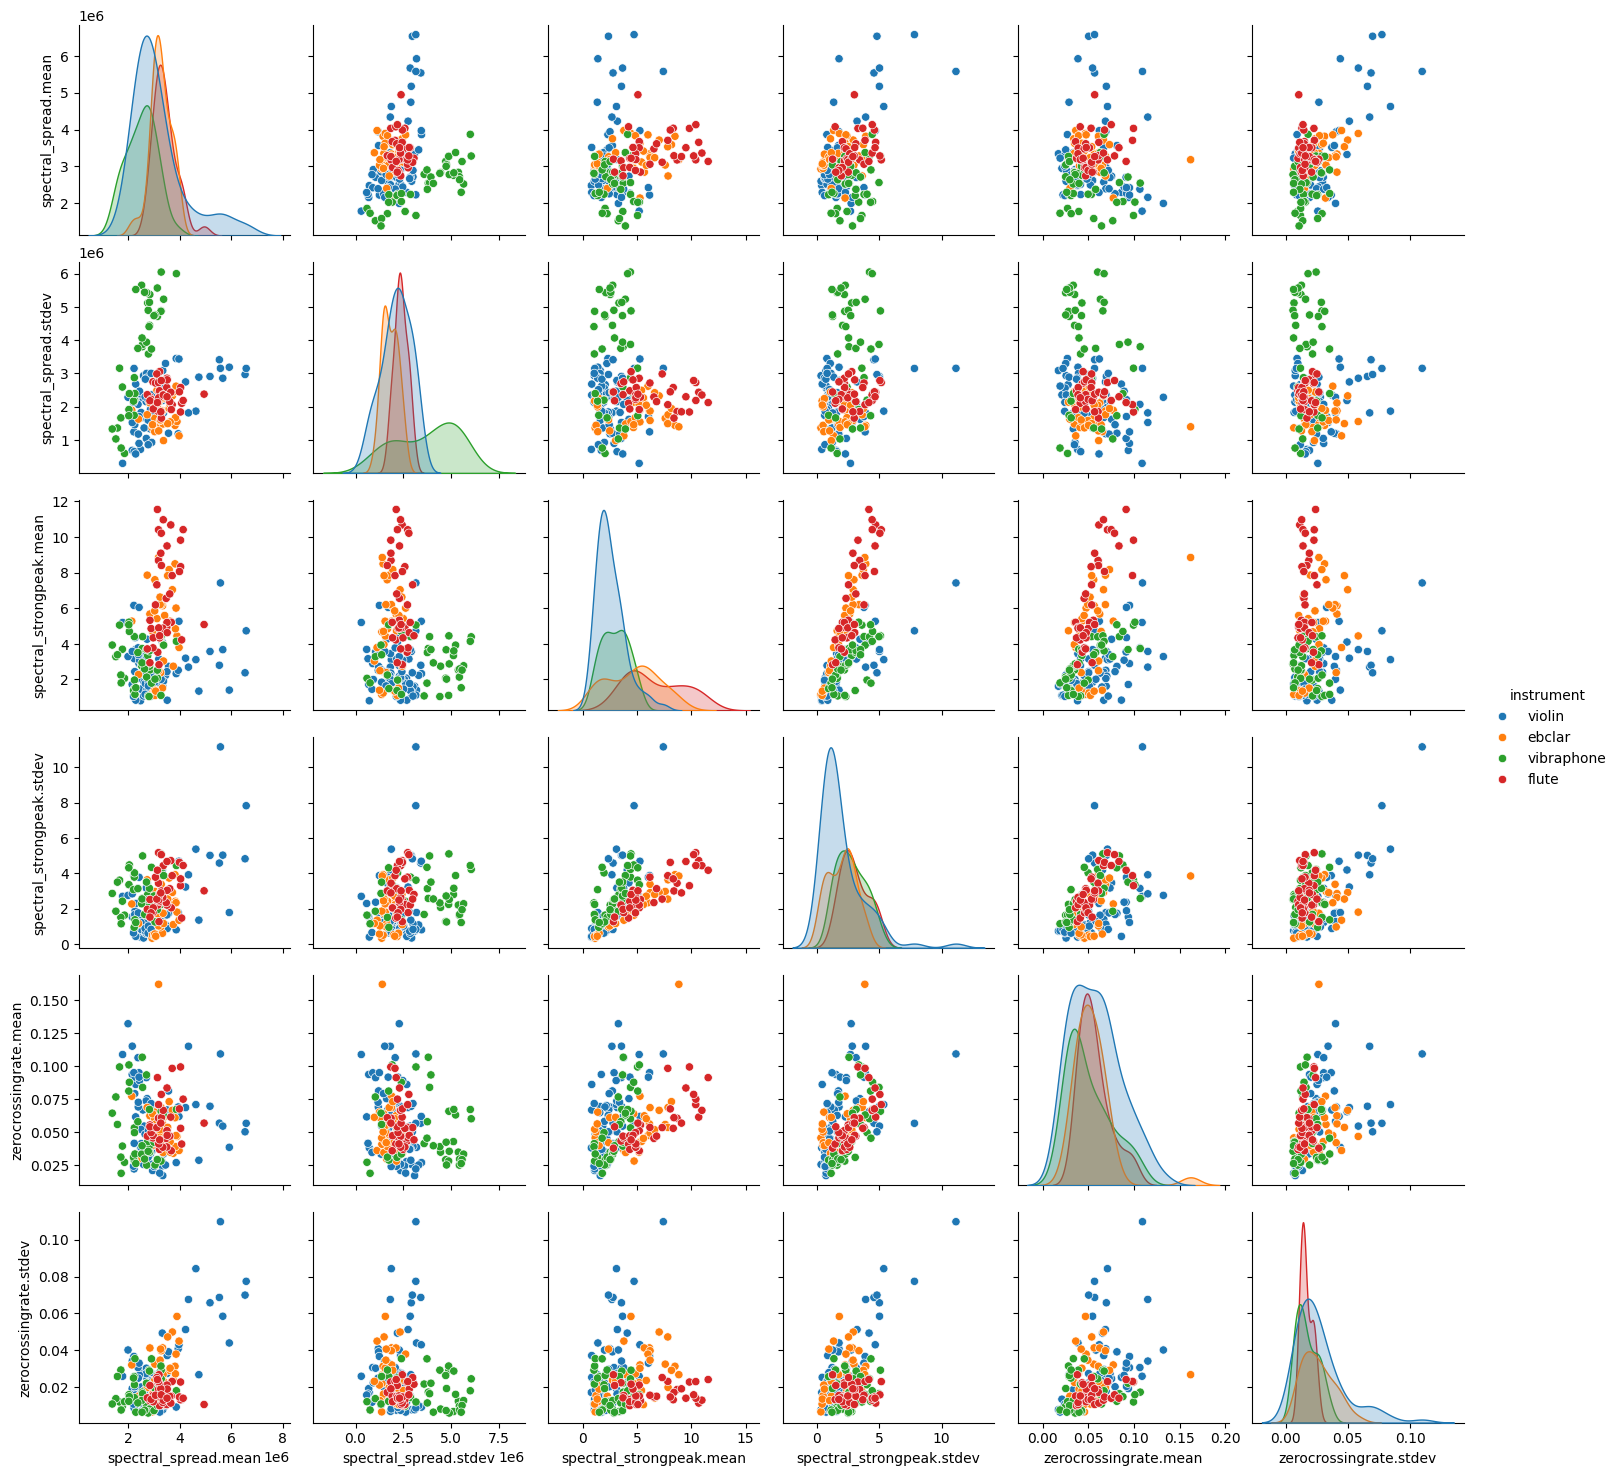

In [ ]:
sns.pairplot(data.iloc[:, -7:], hue = "bird");

As the next step, having a look at descriptive statistics of the features would be useful. Let's do that:

In [ ]:
#Descriptive statistics of the features:
data.describe()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,...,193.000000,193.000000,193.000000,193.000000,1.930000e+02,1.930000e+02,193.000000,193.000000,193.000000,193.000000
mean,0.986378,18.737075,3.533494,0.430367,0.102611,283.950582,628.912602,3.632872,4.466254,9.637900,...,1540.656583,760.391834,3.335842,1.303501,3.089809e+06,2.443494e+06,3.835344,2.347946,0.055322,0.022904
std,0.006414,4.673740,1.205451,0.079074,0.040251,999.686912,2476.936626,6.138558,7.892058,6.017747,...,710.809230,561.415939,1.765829,0.898024,8.214682e+05,1.145186e+06,2.399718,1.485965,0.023783,0.015384
min,0.944595,7.485432,1.186290,0.260509,0.030590,-1.065718,0.525588,-7.482060,0.199631,0.358621,...,448.608398,5.137959,0.950115,0.320257,1.384230e+06,3.002142e+05,0.805182,0.336106,0.017263,0.005875
25%,0.982277,15.009151,2.775762,0.367775,0.072193,5.696008,11.835292,0.806964,1.204419,5.727080,...,1003.193909,388.462433,2.298168,0.673145,2.620600e+06,1.742078e+06,1.990634,1.165608,0.038632,0.012656
50%,0.990684,18.754087,3.416812,0.422367,0.098510,11.744921,29.479965,1.685290,2.010876,8.556026,...,1378.125000,627.297607,2.775609,0.956109,3.019483e+06,2.246068e+06,3.288787,2.212920,0.051336,0.018890
75%,0.990684,22.895193,4.060770,0.488050,0.125469,57.957668,69.372818,3.784953,3.243660,13.196888,...,2060.806641,990.779785,3.632506,1.734676,3.373290e+06,2.829685e+06,5.056060,3.150032,0.067383,0.027325
max,0.990684,26.508204,8.019904,0.636220,0.264137,9113.939453,22528.560547,33.979145,56.715858,26.559134,...,4256.789551,2818.890137,9.847373,5.231193,6.582902e+06,6.047942e+06,11.551766,11.142892,0.162156,0.109800


**Observation:** min, max, mean values of the features vary a lot, we need to normalise them. Some of the features (such as average loudness) may be irrelevant for the task (check variance of the features). For simplicity of the code here, we will keep all the features as is, but you should consider removing irrelevant features from the list.

### Preprocessing of the features

**Normalisation of the features**

In [ ]:
data_modif = data.copy()
#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [ ]:
data_modif.describe()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,...,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,0.906580,0.594489,0.358659,0.453085,0.305674,0.031285,0.027891,0.268052,0.075451,0.352418,...,0.286149,0.262405,0.270449,0.196393,0.324531,0.354477,0.282265,0.186063,0.261462,0.170472
std,0.139165,0.244277,0.173317,0.211131,0.172236,0.109673,0.109950,0.148069,0.139665,0.230787,...,0.187114,0.198187,0.199125,0.183935,0.150736,0.207591,0.223232,0.137546,0.164896,0.146910
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.817586,0.399427,0.252744,0.285502,0.178097,0.000756,0.000502,0.199922,0.017779,0.198267,...,0.145630,0.131815,0.151513,0.069582,0.231878,0.207605,0.110310,0.076758,0.146183,0.073513
50%,1.000000,0.595018,0.341228,0.430805,0.287208,0.001420,0.001285,0.221106,0.032048,0.312872,...,0.242992,0.213836,0.206212,0.119278,0.315735,0.326723,0.231106,0.173670,0.233621,0.132680
75%,1.000000,0.811299,0.435925,0.609888,0.405220,0.006489,0.003056,0.271748,0.053836,0.490001,...,0.423351,0.341355,0.302240,0.263035,0.388475,0.426090,0.395556,0.259458,0.344594,0.213408
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Observation:** Now the features are normalised in [0,1] range, proceed to converting data into matrices that can be fed into classifiers.

**IMPORTANT:** Various other preprocessing may be required based on the nature of your data. Refer to your machine learning course for preprocessing steps. We will also skip discussions on feature selection (another important topic) here and leave it to your machine learning course.

We should check if our data is balanced:

In [ ]:
data_modif.bird.value_counts()

instrument
violin        76
vibraphone    42
ebclar        39
flute         36
Name: count, dtype: int64

**Observation:** our data is imbalanced, ups.... refer to your machine learning course for the problem of working with imbalanced datasets. Here, we will simply throw out some samples to balance our data

### Balancing the data
Let's simply pick 36 samples randomly from each instrument samples (since the lowest number of samples in a class is 36 (flute))

In [ ]:
min_number = data_modif.bird.value_counts()['flute']
violin_data = data_modif[data_modif.bird == 'violin'].sample(n = min_number, random_state = 42)
vibraphone_data = data_modif[data_modif.bird == 'vibraphone'].sample(n = min_number)
ebclar_data = data_modif[data_modif.bird == 'ebclar'].sample(n = min_number)
flute_data = data_modif[data_modif.bird == 'flute']
#Merging after downsampling
data_modif = pd.concat([ebclar_data, flute_data, violin_data, vibraphone_data])
#Checking the balance again
data_modif.bird.value_counts()

instrument
ebclar        36
flute         36
violin        36
vibraphone    36
Name: count, dtype: int64

## Training an automatic classifier and testing it

**Preparing data arrays for features (inputs, X) and labels (outputs, y):**

Now, we can form the input-output matrices that can be fed into classifiers. You can refer to [the tutorials of the scikit learn package](https://scikit-learn.org/stable/tutorial/index.html) to get familiar with the input-output formats.

In [ ]:
#input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 
#Creating output values
data_modif.bird = pd.Categorical(data_modif.bird)#convert to categorical data
y = np.array(data_modif.bird.cat.codes) #create label encoded outputs
#Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [6.97315193e-01 7.94984284e-01 2.63631626e-01 3.68659158e-01
 2.55698118e-01 7.41823621e-04 2.79965416e-04 2.39191862e-01
 1.06344439e-02 4.09829213e-01 5.74524151e-01 7.03946034e-01
 2.26071004e-01 9.23093532e-02 3.35891853e-01 2.67176390e-01
 2.72410967e-01 3.02794201e-01 6.18654879e-03 1.42035320e-02
 5.87345701e-01 8.78483571e-02 4.42405712e-01 1.45880643e-01
 4.22501854e-01 1.55867608e-01 8.46954624e-01 0.00000000e+00
 9.03299932e-01 4.75150131e-02 8.44836051e-01 0.00000000e+00
 5.29847183e-01 1.37206738e-01 3.90754505e-01 2.47316958e-01
 1.22219725e-04 4.33599184e-05 5.46069332e-02 2.63498397e-03
 1.90687182e-01 2.85055736e-01 2.92067945e-01 8.03237628e-02
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.23957956e-01 6.03467056e-01 1.88651224e-01 3.07354381e-01
 4.21681432e-01 2.73746998e-01 4.68152886e-01 8.86454752e-02
 5.56426852e-01 8.73172128e-02 9.07524071e-03 3.29269053e-03
 2.05174829e-04 2.40346765e-04 1.11679633e-01 6.640193

Let's check content of the outputs vector 

In [ ]:
#All output values: ebclar: 0, flute: 1, vibraphone: 2, violin: 3
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


**Splitting data into train and test subsets**

In [ ]:
#Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [ ]:
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (96, 84) , Size of train output vector:  (96,)
Size of test features matrix:  (48, 84) , Size of test output vector:  (48,)


**Defining the machine learning model and training it**

Now we can train a machine learning model. Let's pick a Support Vector Machine (SVM) model and feed our data to train it.

In [ ]:
from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))
clf.fit(X_train, y_train)                         

SVC(gamma=0.14588085094710526)

**Testing the model**

The model is trained. Now, one can perform prediction using the model for a given set of features. If we feed the features of the test set, we expect to find the classes of the test set (true values of it are stored in y_test). We will refer to the output as "predicted classes (y_pred)."

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
#Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([ True,  True,  True,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True], dtype=bool)

In [ ]:
#Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.8125


**Observation:** the accuracy looks good but keep in mind that we have a small dataset and simply obtained a random subset for testing. **We also had an important bias !!:** we had formed our segments set by splitting larger audio files. That means a test segment may be coming from a recording which also provided some train segments. **Any other biases you spotted?**

**!!! Be suspicious when you hit over 0.9 in the first run:**
Check your code. Check if your test set represents a real life scenario and is completely independent of the train set.

As the final step, let's also print the **confusion matrix**

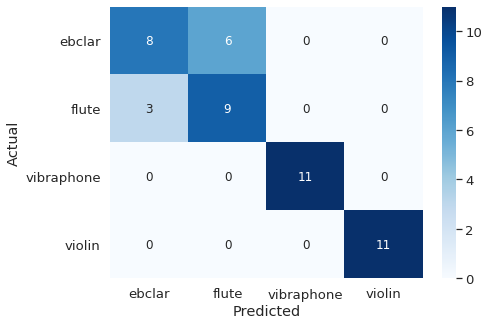

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.bird)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

**Stand-alone use of a trained model:** 

Now that we have a trained model, we have the tools to perform automatic instrument classification of isolated notes. Below, you find the code to run classification on audio files. This cell does not aim testing (because it also includes the training samples) but just a demonstration of the predictions of our model.

In [ ]:
#Class names dictionary
classes = { 0: 'ebclar', 1: 'flute', 2: 'vibraphone', 3: 'violin'}

#Here is the standalone function to run prediction for a given audio file
def predict_bird(file, selected_feature_names, normalizer, classes, classifier):
    '''Predicts the bird class for the given audio file
    '''
    #Extract features for a given file
    features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(file)
    #Pick the features we have used in our model
    selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
    #Applying learned scaling to the features
    scaled_features = min_max_scaler.transform(np.array(selected_features).reshape(1, -1))

    #Running prediction
    y_pred = classifier.predict(scaled_features)
    #Return predicted class 
    return classes[y_pred[0]]
#--------------------------------------------------------------------
#Running prediction on individual files
for file in segment_files:
    bird_pred = predict_bird(file, scalar_lowlevel_descriptors, min_max_scaler, classes, clf)

    #Printing the output
    print(file, " predicted as ", bird_pred)

#!!! This is not a test (as it also contains training samples) but a simple demonstration 
# running standalone classifier on all files

instrument/segments/flute_0.wav  predicted as  flute
instrument/segments/flute_1.wav  predicted as  flute
instrument/segments/flute_2.wav  predicted as  flute
instrument/segments/flute_3.wav  predicted as  flute
instrument/segments/flute_4.wav  predicted as  flute
instrument/segments/flute_5.wav  predicted as  flute
instrument/segments/flute_6.wav  predicted as  flute
instrument/segments/flute_7.wav  predicted as  flute
instrument/segments/flute_8.wav  predicted as  flute
instrument/segments/flute_9.wav  predicted as  flute
instrument/segments/flute_10.wav  predicted as  flute
instrument/segments/flute_11.wav  predicted as  flute
instrument/segments/flute_12.wav  predicted as  flute
instrument/segments/flute_13.wav  predicted as  flute
instrument/segments/flute_14.wav  predicted as  flute
instrument/segments/flute_15.wav  predicted as  flute
instrument/segments/flute_16.wav  predicted as  flute
instrument/segments/flute_17.wav  predicted as  flute
instrument/segments/flute_18.wav  pred

instrument/segments/EbClar_38.wav  predicted as  ebclar
instrument/segments/Vibraphone_0.wav  predicted as  vibraphone
instrument/segments/Vibraphone_1.wav  predicted as  vibraphone
instrument/segments/Vibraphone_2.wav  predicted as  vibraphone
instrument/segments/Vibraphone_3.wav  predicted as  vibraphone
instrument/segments/Vibraphone_4.wav  predicted as  vibraphone
instrument/segments/Vibraphone_5.wav  predicted as  vibraphone
instrument/segments/Vibraphone_6.wav  predicted as  vibraphone
instrument/segments/Vibraphone_7.wav  predicted as  vibraphone
instrument/segments/Vibraphone_8.wav  predicted as  vibraphone
instrument/segments/Vibraphone_9.wav  predicted as  vibraphone
instrument/segments/Vibraphone_10.wav  predicted as  vibraphone
instrument/segments/Vibraphone_11.wav  predicted as  vibraphone
instrument/segments/Vibraphone_12.wav  predicted as  vibraphone
instrument/segments/Vibraphone_13.wav  predicted as  vibraphone
instrument/segments/Vibraphone_14.wav  predicted as  vibra

### Comparing classifiers

Above, we have carried tests for one type of classifier. It is a common practice to compare performances of various classifiers with various settings. Below, we provide an example of such comparison on a limited set of classifiers. 

In [ ]:
#Edited version of https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
import warnings
warnings.filterwarnings('ignore')#suppress warnings
#importing various classifiers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma = 1 / (X_train.shape[-1] * X_train.var())),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB()]

names = ["KNN", "Linear SVM", "RBF SVM", "Gaussian Process","Neural Net", "Naive Bayes"]

#Creating empty list of scores for each classifier, we will append test results to these lists 
scores = {}
for name in names:
    scores[name] = []

#Let's split our data into test and train
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

#Let's run 10 random experiments, collect scores for each classifier 
num_tests = 10
for iteration_number in range(num_tests):
    x_train, x_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 1/num_tests, random_state = iteration_number)
    #normalisation of the data (learned from training data, applied to test data)
    scaler = StandardScaler().fit(x_train)
    norm_x_train = scaler.transform(x_train)
    norm_x_val = scaler.transform(x_val)
    
    # test over each classifier
    for name, clf in zip(names, classifiers):
        clf.fit(norm_x_train, y_train)#train
        score = clf.score(norm_x_val, y_val)#test
        scores[name].append(score)

for name, score in scores.items():
    print("{0}: acc = {1:1.2f}, +-{2:1.2f},\tvalues: {3}".format(name, np.mean(score), np.std(score), np.around(score, decimals = 2)))


KNN: acc = 0.95, +-0.06,	values: [ 1.    0.92  0.92  0.83  0.92  1.    1.    0.92  1.    1.  ]
Linear SVM: acc = 0.97, +-0.04,	values: [ 1.    1.    1.    0.92  0.92  1.    1.    0.92  1.    1.  ]
RBF SVM: acc = 0.76, +-0.18,	values: [ 0.92  0.83  0.83  0.33  0.75  0.5   0.83  0.83  0.92  0.83]
Gaussian Process: acc = 0.78, +-0.21,	values: [ 1.    0.5   0.92  0.92  1.    0.42  0.67  0.58  0.75  1.  ]
Neural Net: acc = 0.97, +-0.04,	values: [ 1.    0.92  0.92  0.92  1.    1.    1.    1.    1.    1.  ]
Naive Bayes: acc = 0.82, +-0.10,	values: [ 0.92  0.75  0.75  0.83  0.67  0.92  0.92  0.67  0.92  0.83]


Following this comparison, you can pick the classifier with highest performance, and report its performance on the test set

In [ ]:
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)
selected_model = SVC(kernel="linear", C=0.025)#Linear SVM performance is high, let's pick that one
selected_model.fit(norm_x_train_val,y_train_val)
y_pred = selected_model.predict(norm_x_test)
print("Number of test samples: ", len(y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Number of test samples:  29
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         6
           3       0.88      1.00      0.93         7

    accuracy                           0.97        29
   macro avg       0.97      0.97      0.97        29
weighted avg       0.97      0.97      0.97        29



<img src=https://miro.medium.com/max/974/1*CNWo23_VnUJPXdfrqbiB0g.jpeg width="400">

<img src=https://www.oreilly.com/library/view/python-data-analysis/9781785282287/graphics/B04223_10_02.jpg width="250">